In [1]:
import os
import re
import string
import warnings
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# sklearn / NLP / utility imports
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer

try:
    import spacy
    spacy_available = True
except Exception:
    spacy_available = False

try:
    import gensim
    from gensim import corpora
    gensim_available = True
except Exception:
    gensim_available = False

try:
    from wordcloud import WordCloud
    wordcloud_available = True
except Exception:
    wordcloud_available = False

# Ensure basic NLTK corpora are present
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)

STOPWORDS = set(stopwords.words('english'))

## Data: 20 Newsgroups (multi-class text classification)
We'll load a subset (few categories) to keep it small and fast.

In [2]:
text_categories = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
try:
    newsgroups = fetch_20newsgroups(subset='train', categories=text_categories, remove=('headers','footers','quotes'))
    texts = newsgroups.data            # list of raw text documents
    text_targets = newsgroups.target   # integer labels
    text_target_names = newsgroups.target_names
    # create a DataFrame for easier EDA pipeline
    df_text = pd.DataFrame({'text': texts, 'target': text_targets})
    print("Text dataset loaded: df_text.shape =", df_text.shape)
except Exception as e:
    # fallback synthetic small text dataset
    df_text = pd.DataFrame({
        'text': [
            "The spacecraft launched successfully.",
            "This image rendering uses ray tracing.",
            "Is there evidence for a deity?",
            "Open-source graphics libraries are evolving fast."
        ] * 50,
        'target': [2,1,0,1] * 50
    })
    text_target_names = ['atheism','graphics','space','religion']
    print("Text fallback dataset created: df_text.shape =", df_text.shape)

Text dataset loaded: df_text.shape = (2034, 2)


In [3]:
# Quick sanity-preview
display(df_text.head(3))
print("- Text sample (first doc):\n", (df_text['text'].iloc[0][:200] + '...') if len(df_text)>0 else 'n/a')

,text,target
0,"Hi,\n\nI've noticed that if you only save a mo...",1
1,"\n\nSeems to be, barring evidence to the contr...",3
2,\n >In article <1993Apr19.020359.26996@sq.sq.c...,2


- Text sample (first doc):
 Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and o...


## Single text-cleaning function
This function lowercases, removes URLs, punctuation, digits, extra whitespace, and stopwords.
It returns cleaned text and token list as needed.

In [4]:
import html

def clean_text_basic(text, remove_stopwords=True, min_token_len=2):
    if not isinstance(text, str):
        return ""
    # HTML unescape
    text = html.unescape(text)
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    # Replace newlines/tabs with space
    text = re.sub(r'[\r\n\t]+', ' ', text)
    # Remove digits and punctuation but keep intra-word apostrophes if desired (here we remove)
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize
    tokens = word_tokenize(text)
    if remove_stopwords:
        tokens = [t for t in tokens if t not in STOPWORDS and len(t) > min_token_len]
    return " ".join(tokens)

# Apply cleaning once
df_text['clean_text'] = df_text['text'].apply(clean_text_basic)
df_text['word_count'] = df_text['clean_text'].apply(lambda x: len(x.split()))
df_text['char_count'] = df_text['clean_text'].apply(len)
df_text['avg_word_len'] = df_text.apply(lambda r: (r['char_count'] / r['word_count']) if r['word_count']>0 else 0, axis=1)

display(df_text[['text','clean_text','word_count']].head(3))

,text,clean_text,word_count
0,"Hi,\n\nI've noticed that if you only save a mo...",noticed save model mapping planes positioned c...,50
1,"\n\nSeems to be, barring evidence to the contr...",seems barring evidence contrary koresh simply ...,30
2,\n >In article <1993Apr19.020359.26996@sq.sq.c...,article apr com msb com mark brader figure see...,21


## Basic descriptive statistics & checks
class balance, word count distribution, example shortest/longest docs

In [7]:
print("Class distribution:")
display(df_text['target'].value_counts())

print("\nWord count stats:")
display(df_text['word_count'].describe().to_frame().T)

print("\nShortest / Longest docs (clean):")
display(df_text.loc[df_text['word_count'].idxmin(), ['clean_text','word_count']])
display(df_text.loc[df_text['word_count'].idxmax(), ['clean_text','word_count']])

Class distribution:


target
2    593
1    584
0    480
3    377
Name: count, dtype: int64


Word count stats:


,count,mean,std,min,25%,50%,75%,max
word_count,2034.0,100.419371,317.755034,0.0,19.0,38.0,76.0,5888.0



Shortest / Longest docs (clean):


clean_text     
word_count    0
Name: 26, dtype: object

clean_text    archive name graphics resources list part last...
word_count                                                 5888
Name: 1733, dtype: object

## Word frequency & top n-grams
Compute top unigrams, bigrams, trigrams (after cleaning)

In [8]:
def top_ngrams(corpus, n=20, ngram_range=(1,1)):
    vec = CountVectorizer(ngram_range=ngram_range, max_features=5000)
    X = vec.fit_transform(corpus)
    freqs = zip(vec.get_feature_names_out(), X.toarray().sum(axis=0))
    return sorted(freqs, key=lambda x: x[1], reverse=True)[:n]

top_unigrams = top_ngrams(df_text['clean_text'], n=20, ngram_range=(1,1))
top_bigrams  = top_ngrams(df_text['clean_text'], n=20, ngram_range=(2,2))
top_trigrams = top_ngrams(df_text['clean_text'], n=20, ngram_range=(3,3))

print("Top unigrams:", top_unigrams[:10])
print("Top bigrams:", top_bigrams[:10])
print("Top trigrams (sample):", top_trigrams[:5])

Top unigrams: [('one', np.int64(1187)), ('would', np.int64(1132)), ('space', np.int64(1063)), ('people', np.int64(794)), ('god', np.int64(749)), ('also', np.int64(724)), ('like', np.int64(682)), ('know', np.int64(594)), ('think', np.int64(585)), ('image', np.int64(558))]
Top bigrams: [('nasa gov', np.int64(97)), ('would like', np.int64(71)), ('anonymous ftp', np.int64(70)), ('space shuttle', np.int64(68)), ('space station', np.int64(68)), ('image processing', np.int64(60)), ('sci space', np.int64(59)), ('alt atheism', np.int64(57)), ('many people', np.int64(54)), ('comp graphics', np.int64(50))]
Top trigrams (sample): [('arc nasa gov', np.int64(27)), ('ames arc nasa', np.int64(25)), ('available anonymous ftp', np.int64(23)), ('ics uci edu', np.int64(22)), ('via anonymous ftp', np.int64(21))]


## Visualizations (word cloud & freq bar plots)
Frequency bar for top unigrams shown always.

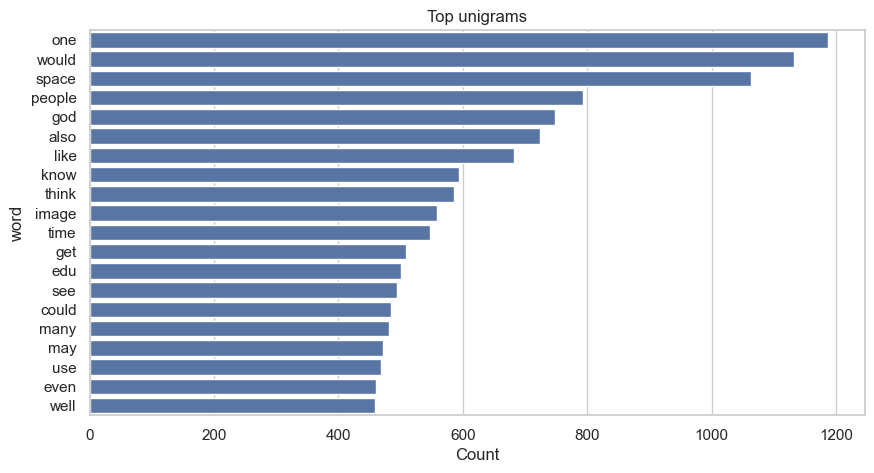

In [9]:
unigram_df = pd.DataFrame(top_unigrams, columns=['word','count']).head(25)
plt.figure(figsize=(10,5))
sns.barplot(data=unigram_df, x='count', y='word')
plt.title("Top unigrams")
plt.xlabel("Count")
plt.show()

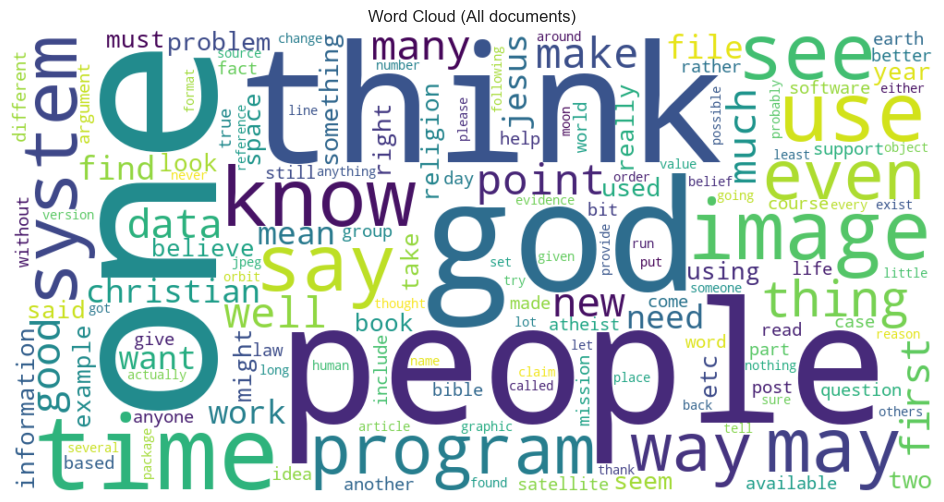

In [10]:
# WordCloud
if wordcloud_available:
    wc = WordCloud(width=1000, height=500, background_color='white', max_words=150)
    wc.generate(" ".join(df_text['clean_text']))
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud (All documents)")
    plt.show()
else:
    print("WordCloud package not available; skipped.")

## Vectorization: CountVectorizer and TF-IDF (max_features fixed for speed)
We compute both and keep sparse matrices for modeling.

In [11]:
MAX_FEATURES = 2000

count_vec = CountVectorizer(max_features=MAX_FEATURES, ngram_range=(1,1))
X_bow = count_vec.fit_transform(df_text['clean_text'])
print("BoW matrix shape:", X_bow.shape)

tfidf_vec = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(1,2))
X_tfidf = tfidf_vec.fit_transform(df_text['clean_text'])
print("TF-IDF matrix shape:", X_tfidf.shape)

# Save feature names if needed
bow_features = count_vec.get_feature_names_out()
tfidf_features = tfidf_vec.get_feature_names_out()

BoW matrix shape: (2034, 2000)
TF-IDF matrix shape: (2034, 2000)


## Embeddings
We also include a helper to auto-download the small model if spaCy is installed but model missing.

In [12]:
# ===== Robust spaCy / fallback embedding block =====

def build_embeddings_with_spacy_or_fallback(df_clean_text, tfidf_matrix, n_svd=100, spacy_nlp=None):
    """
    Try to build embeddings using spaCy doc.vector robustly.
    If spaCy vectors are not available/consistent, fallback to TruncatedSVD on TF-IDF.
    Returns: EMBEDDING_MATRIX (np.ndarray), method_used (str)
    """
    # 1) If spaCy is available and nlp provided, try to use it
    if spacy_nlp is not None:
        print("Attempting to generate spaCy document vectors (robust mode)...")
        docs = spacy_nlp.pipe(df_clean_text.fillna(" ").astype(str).tolist(), disable=["parser","ner"])
        vecs = []
        for doc in docs:
            v = getattr(doc, "vector", None)
            # Ensure v is array-like and has length > 0
            if v is not None and hasattr(v, "__len__") and len(v) > 0 and np.asarray(v).ndim == 1:
                vecs.append(np.asarray(v))
            else:
                # Try averaging non-zero token vectors
                token_vecs = [np.asarray(t.vector) for t in doc if hasattr(t, "vector") and hasattr(t.vector, "__len__") and len(t.vector) > 0]
                if token_vecs:
                    vecs.append(np.mean(np.vstack(token_vecs), axis=0))
                else:
                    vecs.append(None)  # mark failure for this doc

        # If any None entries -> spaCy vectors are unreliable here
        if any(v is None for v in vecs):
            n_failed = sum(1 for v in vecs if v is None)
            print(f"spaCy vectors incomplete: {n_failed} documents had no usable vectors. Falling back to TruncatedSVD.")
        else:
            # verify all vectors have the same dimensionality
            shapes = [v.shape for v in vecs]
            dims = set(s[0] for s in shapes)
            if len(dims) == 1:
                EMBEDDING_MATRIX = np.vstack(vecs)
                print("spaCy embeddings generated successfully. Shape:", EMBEDDING_MATRIX.shape)
                return EMBEDDING_MATRIX, "spacy"
            else:
                print("spaCy produced inconsistent vector sizes. Falling back to TruncatedSVD.")

    # 2) Fallback: TruncatedSVD on TF-IDF
    print("Using TruncatedSVD on TF-IDF as the fallback embedding method.")
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=min(n_svd, tfidf_matrix.shape[1]-1), random_state=42)
    EMBEDDING_MATRIX = svd.fit_transform(tfidf_matrix)
    print("TruncatedSVD embedding matrix shape:", EMBEDDING_MATRIX.shape)
    return EMBEDDING_MATRIX, "svd"

# Usage:
# - If you earlier loaded spaCy into `nlp`, pass it; otherwise pass None
# - Ensure X_tfidf (TF-IDF sparse matrix) is defined (from previous step)
EMBEDDING_MATRIX, embedding_method = build_embeddings_with_spacy_or_fallback(
    df_text['clean_text'],
    X_tfidf,           # TF-IDF sparse matrix from earlier
    n_svd=100,
    spacy_nlp=nlp if ('nlp' in globals() and nlp is not None) else None
)

print("Embedding method used:", embedding_method)
# EMBEDDING_MATRIX is now safe to use (dense numpy array)

Using TruncatedSVD on TF-IDF as the fallback embedding method.
TruncatedSVD embedding matrix shape: (2034, 100)
Embedding method used: svd


## Topic Modeling

In [13]:
if gensim_available:
    # Prepare data for gensim LDA
    texts_tokens = [doc.split() for doc in df_text['clean_text']]
    dictionary = corpora.Dictionary(texts_tokens)
    corpus = [dictionary.doc2bow(text) for text in texts_tokens]
    # Fit LDA
    lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=6, passes=5, random_state=42)
    print("LDA topics (gensim):")
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic {idx}: {topic}")
else:
    # Fallback: print top TF-IDF terms for 6 clusters (by simple KMeans on embeddings)
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=6, random_state=42).fit(EMBEDDING_MATRIX)
    df_text['kmeans_cluster'] = kmeans.labels_
    print("Top TF-IDF terms per cluster (fallback):")
    for cl in sorted(df_text['kmeans_cluster'].unique()):
        idxs = df_text[df_text['kmeans_cluster'] == cl].index
        mean_tfidf = np.array(X_tfidf[idxs,:].mean(axis=0)).ravel()
        top_idx = mean_tfidf.argsort()[-10:][::-1]
        print(f"\nCluster {cl} top terms:")
        print([tfidf_features[i] for i in top_idx])

Top TF-IDF terms per cluster (fallback):

Cluster 0 top terms:
['people', 'one', 'think', 'would', 'religion', 'objective', 'say', 'like', 'morality', 'moral']

Cluster 1 top terms:
['would', 'one', 'like', 'know', 'get', 'could', 'think', 'edu', 'time', 'also']

Cluster 2 top terms:
['thanks', 'graphics', 'anyone', 'please', 'would', 'advance', 'ftp', 'help', 'looking', 'know']

Cluster 3 top terms:
['files', 'file', 'image', 'format', 'windows', 'color', 'card', 'tiff', 'use', 'gif']

Cluster 4 top terms:
['space', 'nasa', 'launch', 'lunar', 'would', 'shuttle', 'moon', 'earth', 'orbit', 'station']

Cluster 5 top terms:
['god', 'jesus', 'believe', 'bible', 'one', 'atheism', 'say', 'satan', 'christian', 'would']


## Sentiment Analysis (VADER)
VADER works well for social-style text and is contained in NLTK.

In [14]:
sia = SentimentIntensityAnalyzer()
df_text['vader_compound'] = df_text['clean_text'].apply(lambda t: sia.polarity_scores(t)['compound'])
# Quick sentiment summary
display(df_text[['clean_text','vader_compound']].sample(3))
print("VADER compound stats:")
display(df_text['vader_compound'].describe().to_frame().T)

,clean_text,vader_compound
508,,0.0000
564,deletion yes sorry got wrong apology deletion ...,0.8779
932,hello know discussed time need teselate sphere...,0.9325


VADER compound stats:


,count,mean,std,min,25%,50%,75%,max
vader_compound,2034.0,0.339456,0.589391,-0.9992,0.0,0.49695,0.858275,0.9999


## Visualize Embeddings (PCA and t-SNE)
Use the EMBEDDING_MATRIX computed earlier. PCA for quick view + t-SNE for non-linear structure.


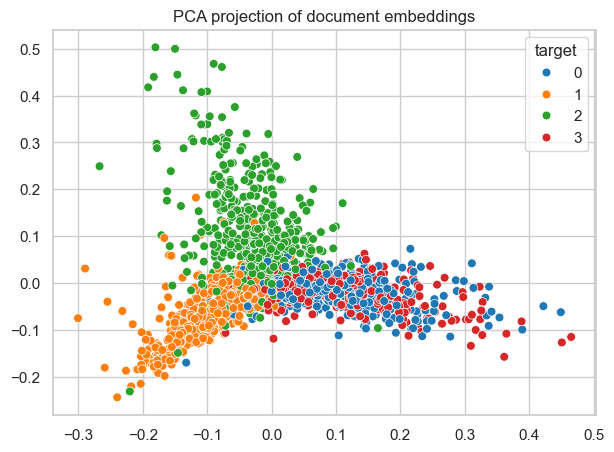

In [16]:
# PCA 2D
pca = PCA(n_components=2, random_state=42)
emb_pca = pca.fit_transform(EMBEDDING_MATRIX)
plt.figure(figsize=(7,5))
sns.scatterplot(x=emb_pca[:,0], y=emb_pca[:,1], hue=df_text['target'], s=40, palette='tab10', legend='brief')
plt.title("PCA projection of document embeddings")
plt.show()

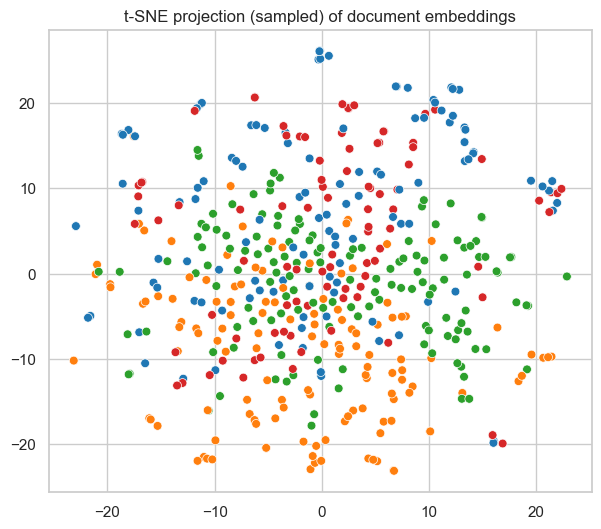

In [18]:
# t-SNE (may be slow for many docs; use a sample if dataset large)
n_sample = min(500, EMBEDDING_MATRIX.shape[0])
if EMBEDDING_MATRIX.shape[0] > n_sample:
    idx_sample = np.random.choice(range(EMBEDDING_MATRIX.shape[0]), n_sample, replace=False)
    emb_to_use = EMBEDDING_MATRIX[idx_sample]
    labels_to_use = np.array(df_text['target'])[idx_sample]
else:
    emb_to_use = EMBEDDING_MATRIX
    labels_to_use = df_text['target'].values

tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
emb_tsne = tsne.fit_transform(emb_to_use)
plt.figure(figsize=(7,6))
sns.scatterplot(x=emb_tsne[:,0], y=emb_tsne[:,1], hue=labels_to_use, s=40, palette='tab10', legend=False)
plt.title("t-SNE projection (sampled) of document embeddings")
plt.show()

## Simple classification baseline (TF-IDF + Logistic Regression)
Quick train/test split and baseline evaluation to demonstrate end-to-end.

In [19]:
X = X_tfidf  # sparse TF-IDF
y = df_text['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# ✅ Dynamic handling of label names
unique_labels = np.unique(y_test)
target_names = [f"Class {label}" for label in unique_labels]

print("Baseline classification results (TF-IDF → LogisticRegression):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))

Baseline classification results (TF-IDF → LogisticRegression):
Accuracy: 0.8255528255528255
              precision    recall  f1-score   support

     Class 0       0.79      0.81      0.80        96
     Class 1       0.91      0.89      0.90       117
     Class 2       0.80      0.92      0.86       119
     Class 3       0.79      0.59      0.67        75

    accuracy                           0.83       407
   macro avg       0.82      0.80      0.81       407
weighted avg       0.83      0.83      0.82       407



## Save TF-IDF features
tfidf_vec and X_tfidf are in memory; to save features names:

In [20]:
pd.DataFrame(tfidf_features, columns=['feature']).to_csv("tfidf_features.csv", index=False)
print("Exported tfidf_features.csv")

Exported tfidf_features.csv
